In [ ]:
# Import required neural network libraries
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import time
import datetime
import pandas as pd
import numpy as np


In [ ]:
# Import Cryto data
# load files that have this format: "{token_ticker}_dataset_with_TA.csv"
# upload oil models as well
from google.colab import files
uploaded = files.upload()


Saving OKB_dataset_with_TA.csv to OKB_dataset_with_TA (1).csv
Saving BNB_dataset_with_TA.csv to BNB_dataset_with_TA (1).csv
Saving HT_dataset_with_TA.csv to HT_dataset_with_TA (1).csv
Saving KCS_dataset_with_TA.csv to KCS_dataset_with_TA (1).csv
Saving FTT_dataset_with_TA.csv to FTT_dataset_with_TA (1).csv
Saving oil_model (7).json to oil_model (7).json
Saving oil_model (7).h5 to oil_model (7).h5


In [ ]:
def run_transfer_model(token_ticker):
  # Convert to DF, features/targets, standarize, and train/test split

  # create df
  crypto_df = pd.read_csv(f"{token_ticker}_dataset_with_TA.csv", index_col='Unnamed: 0', parse_dates=True, infer_datetime_format=True)

  # split into feature and targets
  y = crypto_df['Signal']
  X = crypto_df.drop(columns = ['Signal'])  

  # Drop Columns to get to 43 features
  X.drop(columns=['Open.1', 'High.1', 'Low.1', 'Close.1','PYPL_High_FEATURE', 'PYPL_Close_FEATURE', 'PYPL_Volume_FEATURE', 'MSTR_Volume_FEATURE', 'BK_Volume_FEATURE'], inplace = True)
  # X.shape

  # replace -1 with 0 to optimize data for model
  y = y.replace(-1, 0)

  # Creating training, validation, and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=78)

  # Create the StandardScaler instance
  X_scaler = StandardScaler()

  # Fit the scaler to the features training dataset
  X_scaler.fit(X_train)

  # Scale both the training and testing data from the features dataset
  X_train_scaled = X_scaler.transform(X_train)
  X_test_scaled = X_scaler.transform(X_test)

  # load json and create model
  with open("oil_model (7).json", "r") as json_file:
      model_json = json_file.read()
  loaded_model = model_from_json(model_json)

  # load weights into new model
  file_path = "oil_model (7).h5"
  loaded_model.load_weights(file_path) 

  # The `layers` attribute stores the various layers in the model as a list
  loaded_model.layers

  # Freeze the existing layers of the loaded model
  for layer in loaded_model.layers[0:-1]:
      layer.trainable = False

  # Create a new DNN to hold the old one
  transfer_model = Sequential()
  # Go through each layer, skipping the last layer
  for layer in loaded_model.layers[:-1]: 
      transfer_model.add(layer)

  # Compile the Sequential model
  transfer_model.compile(
      loss="binary_crossentropy", 
      optimizer="adam", 
      metrics=[
          "accuracy",
          # tf.keras.metrics.TruePositives(name="tp"),
          # tf.keras.metrics.TrueNegatives(name="tn"),
          # tf.keras.metrics.FalsePositives(name="fp"),
          # tf.keras.metrics.FalseNegatives(name="fn"),
          # tf.keras.metrics.Precision(name="precision"),
          # tf.keras.metrics.Recall(name="recall"),
          # tf.keras.metrics.AUC(name="auc"),
      ]
  )

  epochs = 100

  # Fit the model
  training_history = transfer_model.fit(X_train_scaled,y_train, 
                      validation_data=(X_val, y_val),
                      epochs=epochs,
                      batch_size=32,
                      shuffle=True)

  # Plotting loss
  loss_df = pd.DataFrame(
      {
          "Epoch": range(1, epochs + 1),
          "Train": training_history.history["loss"],
          "Val": training_history.history["val_loss"],
      }
  )
  loss_df.set_index("Epoch", inplace=True)
  loss_polot = loss_df.plot(title="Loss") 
  
  # Plotting accuracy
  accuracy_df = pd.DataFrame(
      {
          "Epoch": range(1, epochs + 1),
          "Train": training_history.history["accuracy"],
          "Val": training_history.history["val_accuracy"],
      }
  )
  accuracy_df.set_index("Epoch", inplace=True)
  accuracy_plot = accuracy_df.plot(title="Accuracy")   

  # # Plotting AUC
  # auc_df = pd.DataFrame(
  #     {
  #         "Epoch": range(1, epochs + 1),
  #         "Train": training_history.history["auc"],
  #         "Val": training_history.history["val_auc"],
  #     }
  # )
  # auc_df.set_index("Epoch", inplace=True)
  # auc_plot = auc_df.plot(title="AUC")  

  # Evaluate the model loss and accuracy metrics using the evaluate method and the test data
  model_loss, model_accuracy = transfer_model.evaluate(X_test_scaled, y_test, verbose=2)

  # Display the evaluation results
  return f"{token_ticker}'s Transfer Learning model has Loss: {model_loss}, Accuracy: {model_accuracy}", loss_polot, accuracy_plot, #auc_plot


Epoch 1/100
15/15 [==============================] - 1s 15ms/step - loss: 6.1464 - accuracy: 0.2397 - val_loss: 7.0359 - val_accuracy: 0.3636
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 6.1527 - accuracy: 0.2462 - val_loss: 7.0359 - val_accuracy: 0.3636
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 5.9588 - accuracy: 0.2418 - val_loss: 7.0359 - val_accuracy: 0.3636
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 5.9454 - accuracy: 0.2462 - val_loss: 7.0359 - val_accuracy: 0.3636
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 6.0495 - accuracy: 0.2462 - val_loss: 7.0359 - val_accuracy: 0.3636
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 6.0262 - accuracy: 0.2418 - val_loss: 7.0359 - val_accuracy: 0.3636
Epoch 7/100
15/15 [==============================] - 0s 5ms/step - loss: 6.1431 - accuracy: 0.2484 - val_loss: 7.0359 - val_accuracy: 0.3636
Epoch 8/100


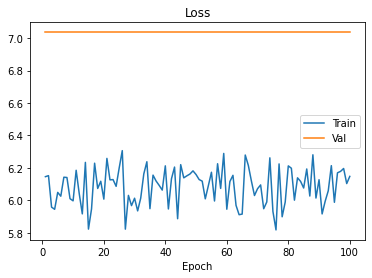

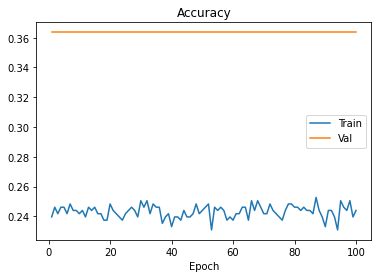

In [ ]:
print(run_transfer_model('BNB'))

Epoch 1/100
15/15 [==============================] - 1s 15ms/step - loss: 5.5489 - accuracy: 0.2680 - val_loss: 8.3221 - val_accuracy: 0.1169
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 5.3789 - accuracy: 0.2658 - val_loss: 8.3221 - val_accuracy: 0.1169
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 5.2774 - accuracy: 0.2702 - val_loss: 8.3221 - val_accuracy: 0.1169
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 5.3443 - accuracy: 0.2702 - val_loss: 8.3221 - val_accuracy: 0.1169
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 5.3764 - accuracy: 0.2723 - val_loss: 8.3221 - val_accuracy: 0.1169
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 5.4831 - accuracy: 0.2593 - val_loss: 8.3221 - val_accuracy: 0.1169
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 5.3190 - accuracy: 0.2593 - val_loss: 8.3221 - val_accuracy: 0.1169
Epoch 8/100


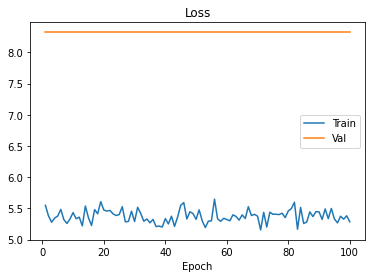

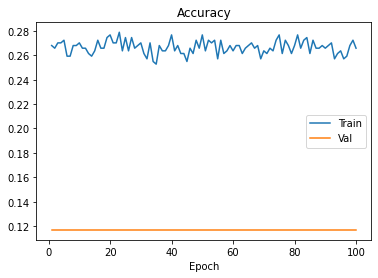

In [ ]:
print(run_transfer_model('FTT'))

Epoch 1/100
15/15 [==============================] - 1s 16ms/step - loss: 6.2294 - accuracy: 0.3224 - val_loss: 8.1100 - val_accuracy: 0.0065
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 6.1416 - accuracy: 0.3203 - val_loss: 8.1100 - val_accuracy: 0.0065
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 5.9483 - accuracy: 0.3094 - val_loss: 8.1100 - val_accuracy: 0.0065
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 6.2751 - accuracy: 0.3050 - val_loss: 8.1100 - val_accuracy: 0.0065
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 5.9219 - accuracy: 0.3007 - val_loss: 8.1100 - val_accuracy: 0.0065
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 6.3194 - accuracy: 0.3072 - val_loss: 8.1100 - val_accuracy: 0.0065
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 6.1044 - accuracy: 0.3072 - val_loss: 8.1100 - val_accuracy: 0.0065
Epoch 8/100


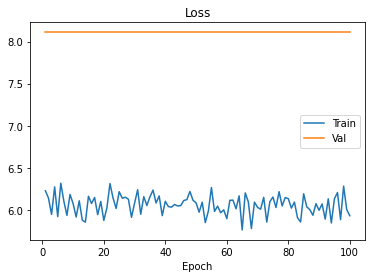

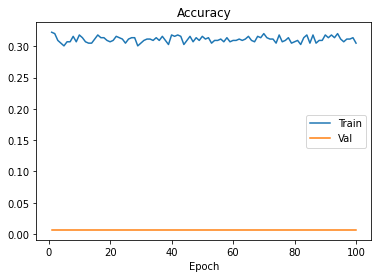

In [ ]:
print(run_transfer_model('KCS'))

In [ ]:
# #Imports oil model
# from tensorflow.keras.models import model_from_json

# """
# This code needs to be adapted to the specific file names and path variable of the oil model we create
# """
# # load json and create model
# file_path = ("../Resources/model.json")
# with open("../Resources/model.json", "r") as json_file:
#     model_json = json_file.read()
# loaded_model = model_from_json(model_json)

# # load weights into new model
# file_path = "../Resources/model.h5"
# loaded_model.load_weights(file_path) 

Next steps are to apply code from:

https://umn.bootcampcontent.com/University-of-Minnesota-Boot-Camp/UofM-VIRT-FIN-PT-09-2022-U-LOLC/-/blob/main/01-Sessions/13-Neural-Networks/3/Activities/06-Ins_Transfer_Learning/Solved/ins_transfer_learning.ipynb